<font size="8"><center><b>Centro Universitário Facens</b></center></font>

<font size="5"><center><b>Avaliação Final: Inteligência Artificial</b></center></font>

<font size="4"><center><b>Detecção Inteligente De Ataques DDOS Utilizando Machine Learning</b></center></font>
  
<font size="3"><center>Prof. Me. Adson Nogueira Alves</center></font>


# **Importando Bibliotecas**


In [ ]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

#!pip install scikeras[tensorflow]

import pyarrow

from IPython.display import display

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
#from scikeras.wrappers import KerasClassifier

import warnings
warnings.filterwarnings('ignore')

# **Leitura dos Dados**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jpsbat","key":"2bbd54c653694e4d018dcd59b78961b0"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dhoogla/cicddos2019

!unzip cicddos2019.zip -d cicddos2019

Dataset URL: https://www.kaggle.com/datasets/dhoogla/cicddos2019
License(s): CC-BY-NC-SA-4.0
  0% 0.00/28.7M [00:00<?, ?B/s]
100% 28.7M/28.7M [00:00<00:00, 1.08GB/s]
Archive:  cicddos2019.zip
  inflating: cicddos2019/DNS-testing.parquet  
  inflating: cicddos2019/LDAP-testing.parquet  
  inflating: cicddos2019/LDAP-training.parquet  
  inflating: cicddos2019/MSSQL-testing.parquet  
  inflating: cicddos2019/MSSQL-training.parquet  
  inflating: cicddos2019/NTP-testing.parquet  
  inflating: cicddos2019/NetBIOS-testing.parquet  
  inflating: cicddos2019/NetBIOS-training.parquet  
  inflating: cicddos2019/Portmap-training.parquet  
  inflating: cicddos2019/SNMP-testing.parquet  
  inflating: cicddos2019/Syn-testing.parquet  
  inflating: cicddos2019/Syn-training.parquet  
  inflating: cicddos2019/TFTP-testing.parquet  
  inflating: cicddos2019/UDP-testing.parquet  
  inflating: cicddos2019/UDP-training.parquet  
  inflating: cicddos2019/UDPLag-testing.parquet  
  inflating: cicddos2019/UD

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Inicializar a API do Kaggle
api = KaggleApi()
api.authenticate()

# Baixar e extrair os arquivos
dataset = 'dhoogla/cicddos2019'
destino = 'dados_cicddos'
api.dataset_download_files(dataset, path=destino, unzip=True)

# Lista de arquivos desejados
arquivos_desejados = {
    'DNS-testing.parquet',
    'NTP-testing.parquet',
    'Syn-testing.parquet',
    'Syn-training.parquet',
    'UDP-testing.parquet',
    'UDP-training.parquet',
    'UDPLag-testing.parquet',
    'UDPLag-training.parquet',
}

# Coletar caminhos de treino e teste
caminhos_treino = []
caminhos_teste = []

for pasta, _, arquivos in os.walk(destino):
    for nome_arquivo in arquivos:
        if nome_arquivo in arquivos_desejados:
            caminho = os.path.join(pasta, nome_arquivo)
            if 'training' in nome_arquivo:
                caminhos_treino.append(caminho)
                print(f"Treino: {caminho}")
            elif 'testing' in nome_arquivo:
                caminhos_teste.append(caminho)
                print(f"Teste: {caminho}")

Dataset URL: https://www.kaggle.com/datasets/dhoogla/cicddos2019
Treino: dados_cicddos/Syn-training.parquet
Treino: dados_cicddos/UDP-training.parquet
Teste: dados_cicddos/DNS-testing.parquet
Teste: dados_cicddos/UDP-testing.parquet
Teste: dados_cicddos/UDPLag-testing.parquet
Teste: dados_cicddos/Syn-testing.parquet
Teste: dados_cicddos/NTP-testing.parquet
Treino: dados_cicddos/UDPLag-training.parquet


# **Análise Exploratória dos Dados**

In [ ]:
# Identificar prefixos comuns entre arquivos de treino e teste
prefixos_treino = [c.split('/')[-1].split('-')[0] for c in caminhos_treino]
prefixos_teste = [c.split('/')[-1].split('-')[0] for c in caminhos_teste]
prefixos_comuns = list(set(prefixos_treino).intersection(prefixos_teste))

# Filtrar arquivos apenas com prefixos comuns
caminhos_treino = [c for c in caminhos_treino if c.split('/')[-1].split('-')[0] in prefixos_comuns]
caminhos_teste = [c for c in caminhos_teste if c.split('/')[-1].split('-')[0] in prefixos_comuns]

# Carregar os dados
df_treino = pd.concat([pd.read_parquet(c, engine='pyarrow') for c in caminhos_treino], ignore_index=True)
df_teste = pd.concat([pd.read_parquet(c, engine='pyarrow') for c in caminhos_teste], ignore_index=True)

print(df_treino.shape, df_teste.shape)

# Remover classe WebDDoS dos dados de teste
df_teste = df_teste[df_teste["Label"] != "WebDDoS"]

# Função para identificar tipos de colunas
def obter_colunas(dataframe, lim_cat=10, lim_card=20):
    col_cat = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_comportando_cat = [col for col in dataframe.columns if dataframe[col].nunique() < lim_cat and dataframe[col].dtypes != "O"]
    cat_alta_card = [col for col in dataframe.columns if dataframe[col].nunique() > lim_card and dataframe[col].dtypes == "O"]

    col_cat = col_cat + num_comportando_cat
    col_cat = [col for col in col_cat if col not in cat_alta_card]

    col_num = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    col_num = [col for col in col_num if col not in num_comportando_cat]

    print(f"Total de observações: {dataframe.shape[0]}")
    print(f"Total de variáveis: {dataframe.shape[1]}")
    print(f"Colunas categóricas: {len(col_cat)}")
    print(f"Colunas numéricas: {len(col_num)}")
    print(f"Colunas categóricas com alta cardinalidade: {len(cat_alta_card)}")
    print(f"Colunas numéricas mas com comportamento categórico: {len(num_comportando_cat)}")
    print("\n")

    return col_cat, col_num, cat_alta_card

col_cat, col_num, cat_alta_card = obter_colunas(df_treino)

print(f"Colunas Categóricas: {col_cat}")
print(f"Colunas Numéricas: {col_num}")
print(f"Alta Cardinalidade: {cat_alta_card}")



(100745, 78) (25834, 78)
Total de observações: 100745
Total de variáveis: 78
Colunas categóricas: 20
Colunas numéricas: 58
Colunas categóricas com alta cardinalidade: 0
Colunas numéricas mas com comportamento categórico: 19


Colunas Categóricas: ['Label', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Colunas Numéricas: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT

In [ ]:
# Combinando treino e teste para uma análise exploratória geral
df_combined = pd.concat([df_treino, df_teste], ignore_index=True)

print("\n--- Informações Básicas ---")
print(f"Total de Registros: {df_combined.shape[0]:,}")
print(f"Total de Features: {df_combined.shape[1]}")
print(f"Valores Ausentes Totais: {df_combined.isnull().sum().sum()}")
print(f"Registros Duplicados Totais: {df_combined.duplicated().sum()}")


--- Informações Básicas ---
Total de Registros: 126,528
Total de Features: 78
Valores Ausentes Totais: 0
Registros Duplicados Totais: 2403


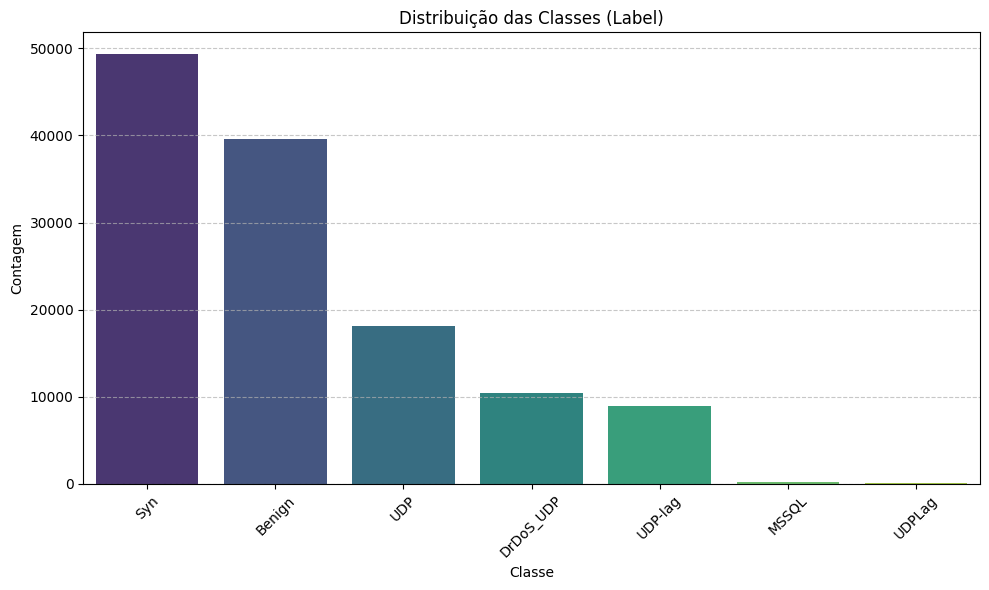

In [ ]:
# Contagem das classes
label_counts = df_combined['Label'].value_counts()

# Plotagem
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

plt.title('Distribuição das Classes (Label)')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Análise dos Tipos de Dados
def obter_colunas(dataframe, lim_cat=10, lim_card=20):
    col_cat = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_comportando_cat = [col for col in dataframe.columns if dataframe[col].nunique() < lim_cat and dataframe[col].dtypes != "O"]
    cat_alta_card = [col for col in dataframe.columns if dataframe[col].nunique() > lim_card and dataframe[col].dtypes == "O"]
    col_cat = col_cat + num_comportando_cat
    col_cat = [col for col in col_cat if col not in cat_alta_card]
    col_num = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    col_num = [col for col in col_num if col not in num_comportando_cat]
    print(f"Total de observações: {dataframe.shape[0]}")
    print(f"Total de variáveis: {dataframe.shape[1]}")
    print(f"Colunas categóricas: {len(col_cat)}")
    print(f"Colunas numéricas: {len(col_num)}")
    print(f"Colunas categóricas com alta cardinalidade: {len(cat_alta_card)}")
    print(f"Colunas numéricas mas com comportamento categórico: {len(num_comportando_cat)}")
    return col_cat, col_num, cat_alta_card

col_cat, col_num, cat_alta_card = obter_colunas(df_combined)

Total de observações: 126528
Total de variáveis: 78
Colunas categóricas: 20
Colunas numéricas: 58
Colunas categóricas com alta cardinalidade: 0
Colunas numéricas mas com comportamento categórico: 19


In [ ]:
print("\nPrimeiras 5 Colunas Categóricas:", col_cat[:5] if col_cat else "Nenhuma")
print("Primeiras 5 Colunas Numéricas:", col_num[:5] if col_num else "Nenhuma")
print("Primeiras 5 Colunas com Alta Cardinalidade:", cat_alta_card[:5] if cat_alta_card else "Nenhuma")


Primeiras 5 Colunas Categóricas: ['Label', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags']
Primeiras 5 Colunas Numéricas: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total']
Primeiras 5 Colunas com Alta Cardinalidade: Nenhuma


In [ ]:
# Dados numéricos
numeric_df = df_combined.select_dtypes(include=[np.number])

display(numeric_df.describe())

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,126528.000000,1.265280e+05,126528.000000,126528.000000,126528.000000,1.265280e+05,126528.000000,126528.000000,126528.000000,126528.000000,...,126528.000000,1.265280e+05,1.265280e+05,1.265280e+05,1.265280e+05,1.265280e+05,126528.0,1.265280e+05,126528.0,126528.0
mean,9.855779,2.108450e+07,7.896584,4.706642,774.313110,2.421656e+03,155.572830,90.588776,105.780624,23.060656,...,5.522651,-9.675721e+06,7.428338e+04,7.497001e+04,1.733665e+05,3.093934e+04,6738315.5,1.611332e+06,8432024.0,5260036.0
std,5.306850,2.970912e+07,25.850236,42.486112,2473.094482,6.748508e+04,291.854156,147.599731,159.327560,79.024910,...,17.545116,1.009409e+08,4.391383e+05,3.731856e+05,7.962259e+05,3.646208e+05,10640903.0,3.200559e+06,12490781.0,9643399.0
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.062719e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0
25%,6.000000,2.216300e+04,2.000000,0.000000,24.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,...,1.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0
50%,6.000000,2.162525e+05,4.000000,2.000000,68.000000,1.200000e+01,6.000000,6.000000,6.000000,0.000000,...,3.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.0
75%,17.000000,4.368770e+07,10.000000,3.000000,1398.000000,3.600000e+01,369.000000,56.000000,308.750000,22.516661,...,7.000000,2.000000e+01,3.625000e+01,3.250000e+01,1.000000e+02,1.000000e+00,12787013.0,2.560448e+06,16456946.5,8522422.5
max,17.000000,1.199975e+08,4648.000000,8029.000000,208524.000000,1.289243e+07,3625.000000,2131.000000,2595.555664,1405.156128,...,3888.000000,1.472000e+03,4.050800e+07,1.063756e+07,4.050800e+07,4.050800e+07,117569200.0,6.961402e+07,117569200.0,117569200.0


In [ ]:
# Amostra dos Dados
display(df_combined.head(10))

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,105,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn
1,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn
2,6,55295858,8,0,48.0,0.0,6.0,6.0,6.0,0.0,...,20,1.0,0.000,1.0,1.0,18431952.0,4641289.0,22000140.0,13184826.0,Syn
3,6,49,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn
4,6,109,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn
5,6,21000186,4,4,24.0,24.0,6.0,6.0,6.0,0.0,...,20,78.0,0.000,78.0,78.0,20999990.0,0.0,20999990.0,20999990.0,Syn
6,6,35999692,10,4,60.0,24.0,6.0,6.0,6.0,0.0,...,20,1024296.5,1448572.625,2048592.0,1.0,11317033.0,3679529.5,14044533.0,7132025.0,Syn
7,6,116,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn
8,6,111,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn
9,6,2,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,Syn


# **Pré-Processamento**
## Remoção e Normalização dos Dados

In [ ]:
# Verificar valores ausentes e duplicados
print(f"Total de valores ausentes: {df_treino.isnull().sum().sum()}")
print(f"Total de linhas duplicadas: {df_treino.duplicated().sum()}")

# Remover duplicadas
df_treino = df_treino.drop_duplicates()

# Remover colunas com valor único
col_valor_unico = [col for col in df_treino.columns if df_treino[col].nunique() == 1]
df_treino.drop(col_valor_unico, axis=1, inplace=True)
df_teste.drop(col_valor_unico, axis=1, inplace=True)

print(df_treino.shape, df_teste.shape)

# Remover colunas altamente correlacionadas
df_numerico = df_treino.select_dtypes(include=[np.number])
matriz_corr = df_numerico.corr().abs()
mascara = np.triu(np.ones(matriz_corr.shape), k=1).astype(bool)
tri_superior = matriz_corr.where(mascara)
col_corr_alta = [col for col in tri_superior.columns if any(tri_superior[col] > 0.8)]

print(f"Total de colunas altamente correlacionadas: {len(col_corr_alta)}")
print("Colunas altamente correlacionadas:", col_corr_alta)

df_treino.drop(col_corr_alta, axis=1, inplace=True)
df_teste.drop(col_corr_alta, axis=1, inplace=True)

print(df_treino.shape, df_teste.shape)

# Separar variáveis independentes e alvo
X_treino, X_valid, y_treino, y_valid = train_test_split(df_treino.drop("Label", axis=1), df_treino["Label"], test_size=0.2, random_state=42)
X_teste, y_teste = df_teste.drop("Label", axis=1), df_teste["Label"]

# Normalizar variáveis de entrada
escalador = MinMaxScaler()
X_treino = escalador.fit_transform(X_treino)
X_valid = escalador.transform(X_valid)
X_teste = escalador.transform(X_teste)

Total de valores ausentes: 0
Total de linhas duplicadas: 2325
(98420, 66) (25783, 66)
Total de colunas altamente correlacionadas: 35
Colunas altamente correlacionadas: ['Total Backward Packets', 'Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']
(98420, 31) (25783, 31)


# **Matriz de Correlação**

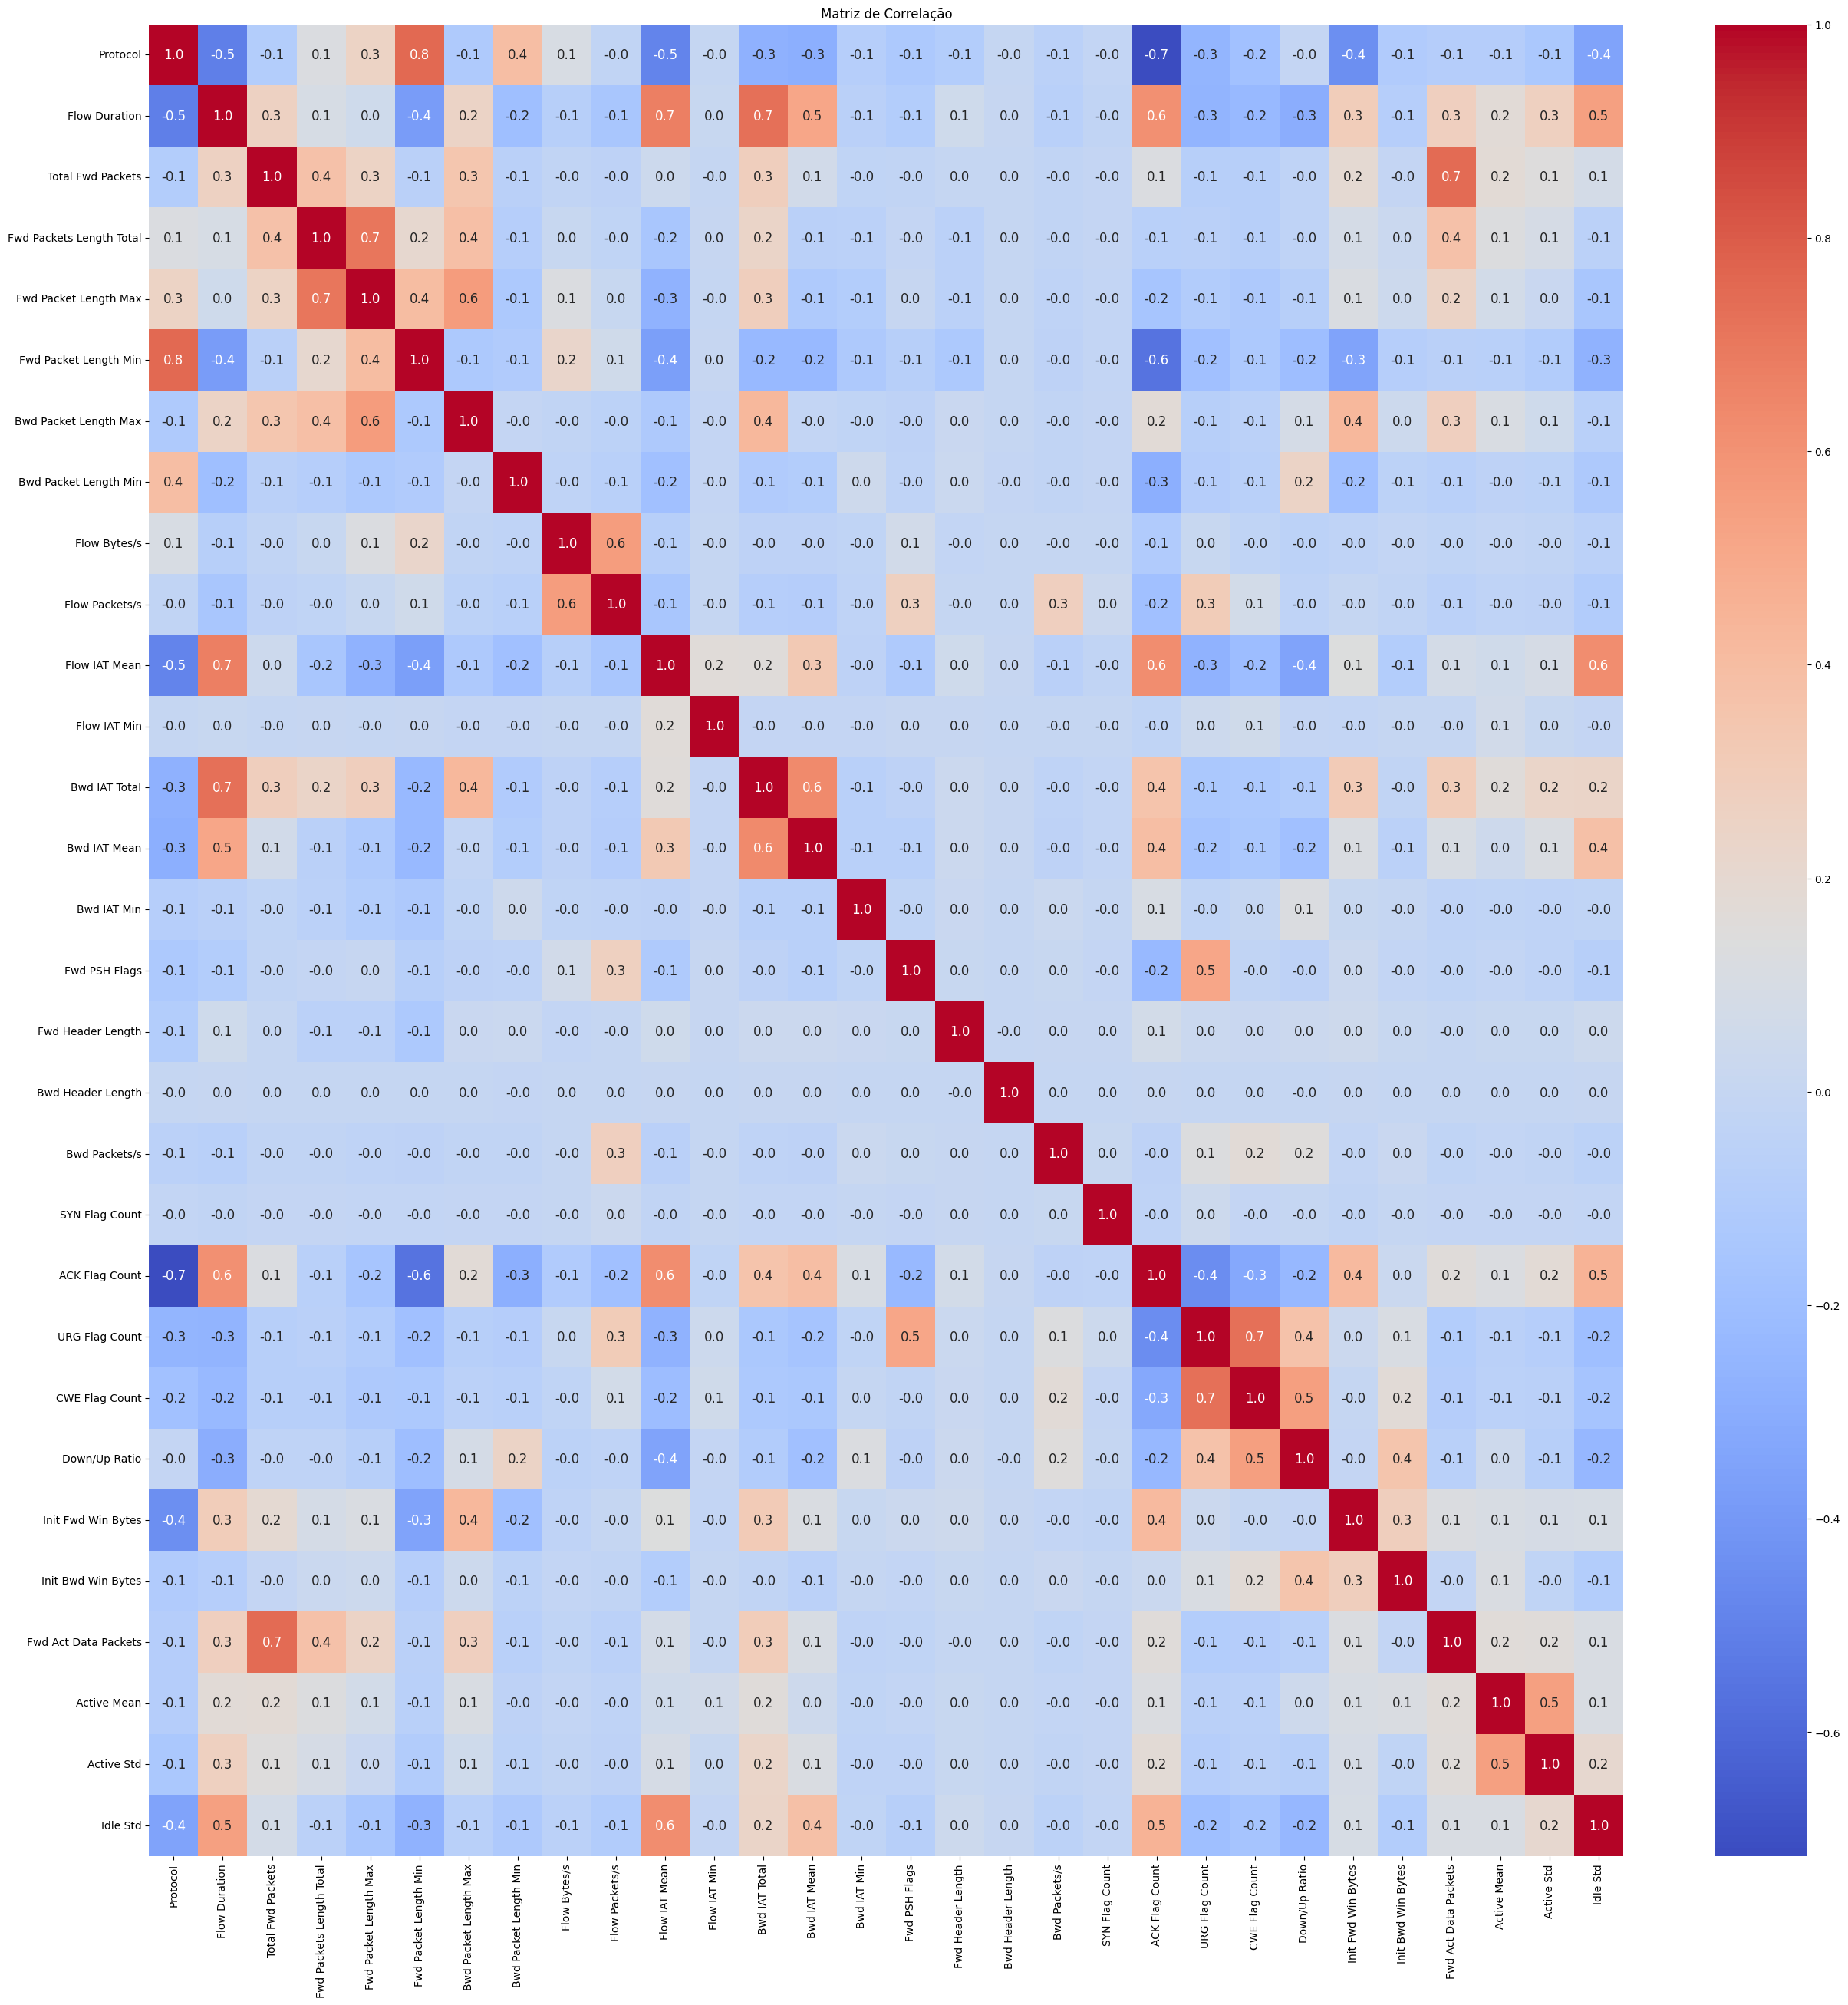

In [ ]:
# Gráfico de Matriz de Correlação para Colunas Numéricas
def matriz_correlacao(dataframe, tamanho_figura):
    if tamanho_figura:
        plt.figure(figsize=tamanho_figura)
    sns.heatmap(
        dataframe.corr(),
        annot=True,
        fmt=".1f",
        cmap="coolwarm",
        annot_kws={"size": 12}
    )
    plt.title("Matriz de Correlação")
    plt.show()

# Exibir a matriz de correlação para as variáveis numéricas
colunas_numericas = df_treino.select_dtypes(include=[np.number])
qtd_colunas_numericas = len(colunas_numericas.columns)
tamanho_figura = (qtd_colunas_numericas + 1, qtd_colunas_numericas + 1)

# Chamada da função
matriz_correlacao(colunas_numericas, tamanho_figura)

In [ ]:
# Maiores Correlações
correlation_matrix = colunas_numericas.corr()

highly_correlated = correlation_matrix[((correlation_matrix > 0.7) | (correlation_matrix < -0.7)) & (correlation_matrix != 1.0)]
highly_correlated_pairs = highly_correlated.unstack().sort_values(ascending=False).drop_duplicates()
filtered_pairs = highly_correlated_pairs[highly_correlated_pairs.notna()]
print(filtered_pairs)

Protocol                  Fwd Packet Length Min    0.752903
Fwd Act Data Packets      Total Fwd Packets        0.746955
Bwd IAT Total             Flow Duration            0.731776
CWE Flag Count            URG Flag Count           0.725583
Fwd Packets Length Total  Fwd Packet Length Max    0.707430
Protocol                  ACK Flag Count          -0.715902
dtype: float64


# **Treinamento do Modelo**

In [ ]:
def treinar_modelo(X_treino, X_teste, y_treino, y_teste):
    classificadores = {
        "Random Forest": RandomForestClassifier(),
        "Rede Neural": "KerasModel"
    }

    lista_metricas = []

    for nome, modelo in tqdm(classificadores.items(), desc="Treinando modelos"):
        print(f"\nTreinando {nome}...")

        if nome == "Rede Neural":
            # Garantir que X seja float32 (Keras exige isso)
            X_treino = X_treino.astype('float32')
            X_teste = X_teste.astype('float32')

            # Converter y para inteiro se necessário
            if y_treino.dtype == 'object' or y_treino.dtype.name == 'category':
                le = LabelEncoder()
                y_treino = le.fit_transform(y_treino)
                y_teste = le.transform(y_teste)

            # Definir saída e função de perda
            if np.unique(y_treino).shape[0] == 2:
                ativacao_saida = 'sigmoid'
                loss = 'binary_crossentropy'
                unidades_saida = 1
            else:
                ativacao_saida = 'softmax'
                loss = 'sparse_categorical_crossentropy'
                unidades_saida = np.unique(y_treino).shape[0]

            # Definir e treinar o modelo
            model = Sequential()
            model.add(Dense(64, input_dim=X_treino.shape[1], activation='relu'))
            model.add(Dense(32, activation='relu'))
            model.add(Dense(unidades_saida, activation=ativacao_saida))
            model.compile(optimizer=Adam(0.001), loss=loss, metrics=['accuracy'])

            model.fit(X_treino, y_treino, epochs=20, batch_size=32, verbose=0, validation_split=0.1)
            _, acuracia = model.evaluate(X_teste, y_teste, verbose=0)
            y_pred_prob = model.predict(X_teste)

            # Converter probabilidades para classes
            if unidades_saida == 1:
                y_pred = (y_pred_prob > 0.5).astype(int)
            else:
                y_pred = np.argmax(y_pred_prob, axis=1)

            modelo = model
            cv_score = np.nan  # não aplicável
        else:
            modelo.fit(X_treino, y_treino)
            y_pred = modelo.predict(X_teste)
            cv_score = np.mean(cross_val_score(modelo, X_treino, y_treino, cv=5))

        acuracia = accuracy_score(y_teste, y_pred)
        precisao = precision_score(y_teste, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_teste, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_teste, y_pred, average='weighted', zero_division=0)

        lista_metricas.append({
            "Modelo": nome,
            "Acurácia": acuracia,
            "Precisão": precisao,
            "Recall": recall,
            "F1": f1,
            "Validação Cruzada": cv_score
        })

    return pd.DataFrame(lista_metricas)

# Rodar o treinamento
resultados = treinar_modelo(X_treino, X_valid, y_treino, y_valid)
display(resultados.style.background_gradient(cmap='viridis'))

Treinando modelos:   0%|          | 0/2 [00:00<?, ?it/s]


Treinando Random Forest...


Treinando modelos:  50%|█████     | 1/2 [00:53<00:53, 53.12s/it]


Treinando Rede Neural...
616/616 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Treinando modelos: 100%|██████████| 2/2 [02:49<00:00, 84.84s/it]


,Modelo,Acurácia,Precisão,Recall,F1,Validação Cruzada
0,Random Forest,0.997104,0.996883,0.997104,0.996943,0.997396
1,Rede Neural,0.994005,0.993032,0.994005,0.993294,nan


# **Métricas e Resultados**

In [ ]:
# Extrair as métricas
acuracia_final = resultados["Acurácia"].iloc[0]
precisao_final = resultados["Precisão"].iloc[0]
revocacao_final = resultados["Recall"].iloc[0]
f1_final = resultados["F1"].iloc[0]
cv_final = resultados["Validação Cruzada"].iloc[0]

# Criar uma média das métricas principais
media_metricas = np.mean([acuracia_final, precisao_final, revocacao_final, f1_final, cv_final])

print(media_metricas)

# Lógica de decisão baseada nessa média geral
if 0.90 <= media_metricas <= 1:
    print("🔴 Ataque detectado")
elif 0.60 <= media_metricas < 0.90:
    print("🟠 Movimentação suspeita detectada")
elif 0.0 <= media_metricas < 0.60:
    print("🟢 Ambiente aparentemente normal")
else:
    print("⚠️ Valor de métricas fora do esperado")


0.9970861921604076
🔴 Ataque detectado
